<a href="https://colab.research.google.com/github/zer0je/HermiNN_GUI/blob/HermiNN_GUI/HermiNN_GUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install anvil-uplink
!pip install plotly


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


ERROR: Operation cancelled by user


<ipython-input-42-af211018720a>:305: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-42-af211018720a>:305: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



KeyboardInterrupt: 

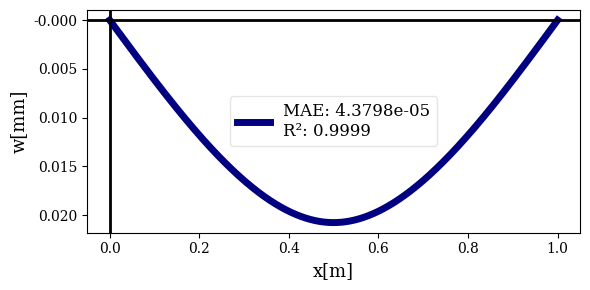

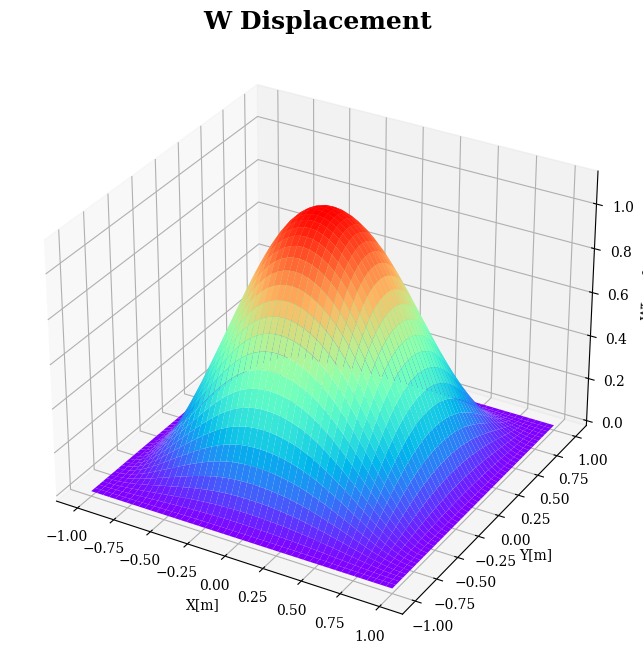

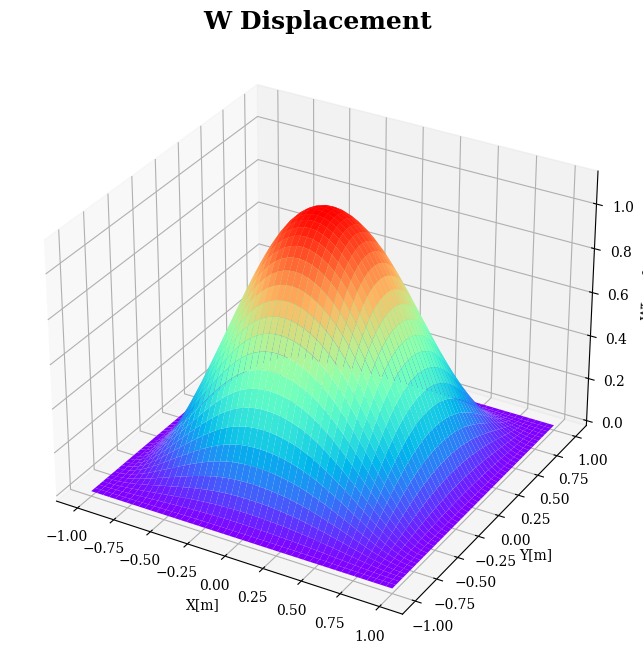

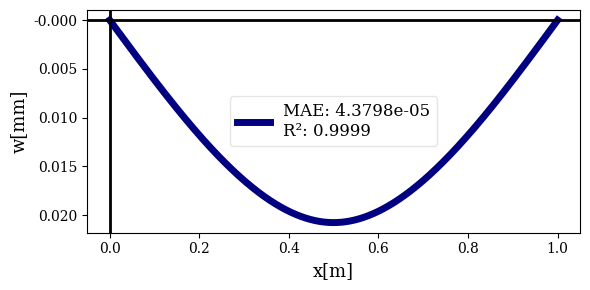

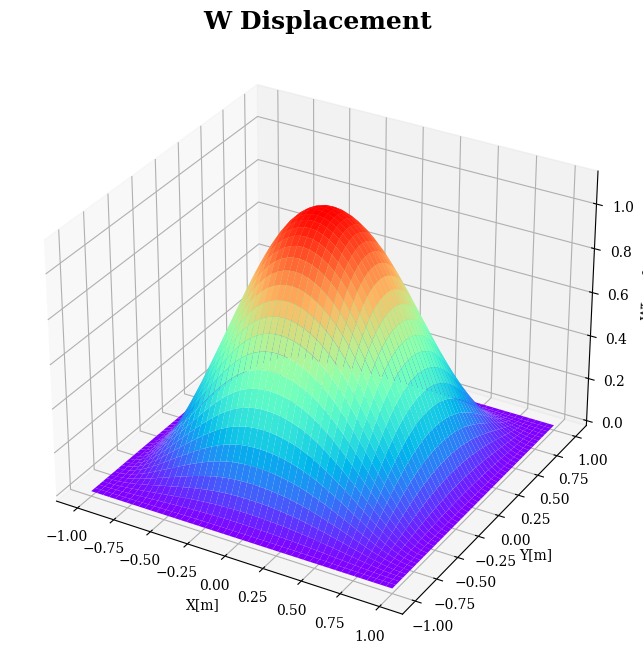

In [42]:
# Import Essentials
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from IPython.display import clear_output
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.linalg import solve
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import joblib
from matplotlib.ticker import FuncFormatter

# Import Anvil Server
import anvil.server
anvil.server.connect("server_YMDOUOCPLSFHGAXO5ASKTZG2-MFWJWUEDDABQBXN2")
import anvil.media


# Hermite Shape Function
class ShapeNet_hermit(nn.Module):
    def __init__(self):
        super(ShapeNet_hermit, self).__init__()

    def N1(self, x):
        return 1 - 3 * x**2 + 2 * x**3
    def N2(self, x):
        return x - 2 * x**2 + x**3
    def N3(self, x):
        return 3 * x**2 - 2 * x**3
    def N4(self, x):
        return - x**2 + x**3


    def forward(self, x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last):
        relu = nn.ReLU()
        if is_first:
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = self.N1(right_x)
            rot = self.N2(right_x)

        elif is_last:
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            disp = self.N3(left_x)
            rot = self.N4(left_x)

        else:
            # Compute both terms
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = (self.N1(right_x) + self.N3(left_x)) - 1
            rot = (self.N2(right_x) + self.N4(left_x)) / 2

        return disp, rot

# Hermite Elements
class HiNet_hermit(nn.Module):
    def __init__(self, starter=-1, final=1, steps=10, DBC_s='x', DBC_f='x', initial_value = 1.0):
        super(HiNet_hermit, self).__init__()
        self.shape_function = ShapeNet_hermit()
        self.steps = steps
        self.x_k_values = torch.linspace(starter, final, steps=self.steps, dtype=torch.float32)
        self.x_k_min_1_values = torch.cat([torch.tensor([0.0]), self.x_k_values[:-1]])
        self.x_k_plu_1_values = torch.cat([self.x_k_values[1:], torch.tensor([0.0])])

        # Initialize trainable DOF parameters for each shape function
        self.fixes = 0
        self.s_s, self.s_f, self.f_s, self.f_f = 0,0,0,0
        if DBC_s == 's':
            self.s_s += 1
            self.fixes += 1
        elif DBC_s == 'f':
            self.s_f += 1
            self.fixes += 2
        if DBC_f == 's':
            self.f_s += 1
            self.fixes += 1
        elif DBC_f == 'f':
            self.f_f += 1
            self.fixes += 2

        num_params = 2 * self.steps - self.fixes
        if isinstance(initial_value, list):
            assert len(initial_value) == num_params, f"Initial value list length {len(initial_value)} does not match expected number of parameters {num_params}."
            self.dof_params = nn.Parameter(torch.tensor(initial_value, dtype=torch.float32))
        else:
            self.dof_params = nn.Parameter(torch.full((num_params,), initial_value))

    def forward(self, x):
        total_output = 0

        dof_counter = 0
        for i in range(self.steps):
            x_k_min_1 = self.x_k_min_1_values[i]
            x_k = self.x_k_values[i]
            x_k_plu_1 = self.x_k_plu_1_values[i]
            is_first = (i == 0)
            is_last = (i == len(self.x_k_values) - 1)
            disp, rot = self.shape_function(x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last)

            if is_first:
                if self.s_s > 0:
                    disp = 0
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.s_f > 0:
                  pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1

            elif is_last:
                if self.f_s > 0:
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.f_f > 0:
                  pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
            else:
                total_output += self.dof_params[dof_counter] * disp
                dof_counter += 1
                total_output += self.dof_params[dof_counter] * rot
                dof_counter += 1
            #print(f'{i}th total output: {total_output}')
        #print(dof_counter)
        return total_output

#------------------------------------------------------------------------------
# 진행 상황 및 결과 호출

@anvil.server.callable
def get_task_progress(task_id):
    task = anvil.server.get_background_task(task_id)
    state = task.get_state() if task.get_state() is not None else {}
    progress = state.get('progress', 0)
    #model_path=state.get('model_path')
    if task.is_running():
        return {
            'running': True,
            'progress': progress,
            'result_text': None
        }
    else:
        return {
            'running': False,
            'progress': progress,
            'result_text': state.get('result_text')
        }

@anvil.server.callable
def create_image(image_path):
    return anvil.media.from_file(image_path, 'image/png')

@anvil.server.callable
def create_html(html_path):
  return anvil.media.from_file(html_path,'text/html')


#-------------------------------------------------------------------------------
# Beam Anlaysis

# 2nd order derivative in x axis
def dw_2(x, w):
    dw_dx = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)[0]
    dw_xx = torch.autograd.grad(dw_dx, x, grad_outputs=torch.ones_like(dw_dx), create_graph=True, retain_graph=True)[0]
    return dw_xx

# Total Potential Energy with Technical Beam Theory(Euler Beam)
def TPE_EB(x, w,E,I,L,P,x_p,q):
    dw_xx = dw_2(x, w)
    U = torch.mean(0.5 * (E * I * dw_xx**2))*L

    position_P=x_p/L
    V = w[int(position_P*(len(w)-1))] * P + torch.mean(w)*q*L

    return U, V


@anvil.server.callable
def launch_calculate_beam(left_condition, right_condition, E, I, L, P, x_p, q, lr, num_epochs):
    task = anvil.server.launch_background_task(
        'calculate_beam', left_condition, right_condition, E, I, L, P, x_p, q, lr, num_epochs
    )
    return task.get_id()

@anvil.server.background_task
def calculate_beam(left_condition, right_condition, E, I, L, P, x_p, q, lr, num_epochs):
  # Proplem Statement for Euler Beam
  left_condition=left_condition
  right_condition=right_condition
  E = float(E)
  I = float(I)
  L = float(L)
  P = float(P)
  x_p=float(x_p)
  q=float(q)
  lr = float(lr)
  num_epochs = int(num_epochs)


  # Initializing HermiNN
  model = HiNet_hermit(0, L, 3, left_condition, right_condition)

  # Sampling coordinate data
  data = torch.linspace(0, L, 10000).unsqueeze(1)  # 입력 크기에 맞게 reshape
  #data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

  # Updated line to avoid the warning and keep gradient tracking
  data = data.clone().detach().requires_grad_(True)

  # Optimizer Settings
  optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=10, history_size=5)
  start_time_ml = time.time()

  def closure():
      optimizer.zero_grad()
      w = model(data)
      U, V = TPE_EB(data, w,E,I,L,P,x_p,q)
      loss = U + V
      loss.backward()
      return loss

  for epoch in range(num_epochs):
    loss = optimizer.step(closure)
    # update progress
    anvil.server.task_state['progress'] = (epoch + 1)

  end_time_ml = time.time()


  # Define the analytic solution function
  def analytic_solution(x,left_condition,right_condition, L, P, E, I, x_p,q):
    w = np.zeros_like(x)

    # Fixed-Free
    if left_condition == 'f' and right_condition == 'x':
        for i in range(len(x)):
            if x[i] < x_p:
                w[i] = (P * x[i]**2 / (6 * E * I)) * (3 * x_p - x[i]) +(q / (24 * E * I)) * x[i]**2 * (6*L**2 - 4*L*x[i] + x[i]**2)
            else:
                w[i] = (P * x_p**2 / (6 * E * I)) * (3 * x[i] - x_p) +(q / (24 * E * I)) * x[i]**2 * (6*L**2 - 4*L*x[i] + x[i]**2)

    # Fixed-Simply Supported
    elif left_condition == 'f' and right_condition == 's':
        for i in range(len(x)):
             if x[i] < x_p:
              w[i] = (P * (L-x_p) / (12* E * I*L**3)) *(x[i])**2 *(3*L**2*(L-x[i])-(L-x_p)**2*(L-x[i])-2*(L-x_p)**2*L) +(q*(L-x[i])/(48*E*I)*(L**3-3*L*(L-x[i])**2+2*(L-x[i])**3))

             else:
              w[i] = (P * (x_p)**2*(L-x[i]) / (12 * E * I*L**3)) * (3*(L-x_p)*L**2-2*L*(L-x[i])**2-(L-x_p)*(L-x[i])**2)+ (q*(L-x[i])/(48*E*I)*(L**3-3*L*(L-x[i])**2+2*(L-x[i])**3))


    # Fixed-Fixed
    elif left_condition == 'f' and right_condition == 'f':
        for i in range(len(x)):
            if x[i] < x_p:
                w[i] = (2*P * (L-x_p)**2*x[i]**2 / (12 * E * I*L**3)) * (3*x_p*L-3*x_p*x[i]-(L-x_p)*x[i])+(q / (24 * E * I)) * x[i]**2 * (L-x[i])**2
            else:
                w[i] = (2*P * (x_p)**2*(L-x[i])**2 / (12 * E * I*L**3)) * (3*(L-x_p)*L-3*(L-x_p)*(L-x[i])-x_p*(L-x[i]))+(q / (24 * E * I)) * x[i]**2 * (L-x[i])**2


    # Simply Supported-Simply Supported
    elif left_condition == 's' and right_condition == 's':
        for i in range(len(x)):
            if x[i] < x_p:
                w[i] = (P * (L-x_p)*x[i]/(6*L*E*I))*(L**2-(L-x_p)**2-x[i]**2) +(q*x[i] / (24 * E * I)) *  (L**3-2*L*(x[i]**2) + x[i]**3)
            else:
                w[i] = (P * x_p*(L-x[i]) / (6*L*E*I)) * (L**2-x_p**2-(L-x[i])**2) +(q*x[i] / (24 * E * I)) *  (L**3-2*L*(x[i]**2) + x[i]**3)



    # Simply Supported-Fixed
    elif left_condition == 's' and right_condition == 'f':
        for i in range(len(x)):
            if x[i] < x_p:
                w[i] = (P * (L-x_p)**2*x[i] / (12 * E * I*L**3)) * (3*x_p*L**2-2*L*x[i]**2-x_p*x[i]**2)+ (q*x[i]/(48*E*I)*(L**3-3*L*x[i]**2+2*x[i]**3))
            else:
                w[i] = (P * x_p / (12* E * I*L**3)) *(L-x[i])**2 *(3*L**2*x[i]-x_p**2*x[i]-2*x_p**2*L) +(q*x[i]/(48*E*I)*(L**3-3*L*x[i]**2+2*x[i]**3))

    # Free-Fixed
    elif left_condition == 'x' and right_condition == 'f':
        for i in range(len(x)):
            if x[i] < x_p:
                w[i] = (P * (L-x_p)**2 / (6 * E * I)) * (3*L-3*x[i]-(L-x_p)) +(q / (24 * E * I)) * (L-x[i])**2 * (6*L**2 - 4*L*(L-x[i]) + (L-x[i])**2)
            else:
                w[i] = (P * (L-x[i])**2 / (6 * E * I)) * (3*(L-x_p)-L+x[i]) +(q / (24 * E * I)) * (L-x[i])**2 * (6*L**2 - 4*L*(L-x[i]) + (L-x[i])**2)

    return -w

  # Sampling coordinate data
  sampling_points = 10000
  data = torch.linspace(0, L, sampling_points).unsqueeze(1)
  data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

  w = model(data)

  # Arrange Trained Data
  data_np = data.detach().numpy()
  w_np = w.detach().numpy()
  w_analytic = analytic_solution(data_np,left_condition,right_condition,L,P,E,I,x_p,q)
  x_fine = np.linspace(0, L, sampling_points)



  # Statistic Values (Learned Solution)
  mae_ml = mean_absolute_error(w_np, w_analytic)
  r2_ml = r2_score(w_np,w_analytic)

  # Setting font
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

  # Custom formatter to display positive values for the y-axis
  def positive_y_formatter(x, pos):
    return f'{-x:.3f}'

  # plot deflection
  plt.figure(figsize=(6,3))
  plt.plot(data_np, w_np, color='navy', linewidth=5)

  # Draw x-axis
  plt.axhline(y=0, color='black', linestyle='-', linewidth=2)

  # Draw z-axis (y=0 axis in this case)
  plt.axvline(x=0, color='black', linestyle='-', linewidth=2)

  # Customize the y-axis to show positive values
  plt.gca().yaxis.set_major_formatter(FuncFormatter(positive_y_formatter))

  plt.xlabel('x[m]',fontsize=13)
  plt.ylabel('w[mm]',fontsize=13)
  plt.tight_layout()

  # Add text box with statistics as a legend entry
  stats_text = f'MAE: {mae_ml:.4e}\nR²: {r2_ml:.4f}'
  plt.legend([stats_text], loc='best', fontsize=12, framealpha=0.5)

  # save image
  image_path = "/tmp/beam_plot.png"
  plt.savefig(image_path)

  # save text result
  w_max=abs(np.min(w_np))*1000
  result_text = (f"Maximum deflection: {w_max:.4f} mm")

  anvil.server.task_state.update({
        'result_text': result_text
    })

  time.sleep(0.2)



#-------------------------------------------------------------------------------
# Plate Analysis

# Data Sampling Function
def train_data_grid(Nx, Ny):
    # Generate x and y coordinates
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)

    # Use meshgrid to generate grid points
    X, Y = np.meshgrid(x, y)

    # Transform grid points into (N, 2) shape
    Xf = np.vstack([X.ravel(), Y.ravel()]).T

    # Convert to PyTorch tensor
    Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

    return Xf

def train_data(Nf, seed=None):
    if seed is not None:
        np.random.seed(seed)

    while True:
        Xf2 = np.random.rand(Nf, 2) * 2 - 1
        # eliminate points at boundary
        Xf2 = Xf2[~((np.isclose(Xf2[:, 0], -1) | np.isclose(Xf2[:, 0], 1)) |
                    (np.isclose(Xf2[:, 1], -1) | np.isclose(Xf2[:, 1], 1)))]
        if len(Xf2) >= Nf:
            break
    Xf2 = Xf2[:Nf]
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf2

# 1st order derivative
def grad_w(xy, w):
    dw_xy = torch.autograd.grad(w, xy, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)
    dw_x = dw_xy[0][:,0]
    dw_y = dw_xy[0][:,1]

    return dw_x, dw_y

# 2nd order derivative
def Laplace_w(xy, w):
    dw_xy = torch.autograd.grad(w, xy, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)
    dw_x = dw_xy[0][:,0]
    dw_y = dw_xy[0][:,1]

    dw_x_xy = torch.autograd.grad(dw_x, xy, grad_outputs=torch.ones_like(dw_x), create_graph=True, retain_graph=True)
    dw_xx = dw_x_xy[0][:,0]
    dw_xy = dw_x_xy[0][:,1]

    dw_y_xy = torch.autograd.grad(dw_y, xy, grad_outputs=torch.ones_like(dw_y), create_graph=True, retain_graph=True)
    dw_yy = dw_y_xy[0][:,1]

    return dw_x, dw_y, dw_xx, dw_xy, dw_yy

# Total Potential Energy based on Plane stress
def TPE_PlaneStress(xy, w,D,q):
    _, _, dw_xx, dw_xy, dw_yy = Laplace_w(xy, w)

    #U_b = D / 2 * ((dw_xx+dw_yy)**2 + 2*(1-mu)*(dw_xy**2 - dw_xx*dw_yy))
    U_b = D / 2 * ((dw_xx+dw_yy)**2)

    U_e = q*w

    #print(U_b.shape), print(U_e.shape)

    return torch.mean(U_b), torch.mean(U_e)


@anvil.server.callable
def launch_calculate_plate(boundary_condition, E, mu, W, H, t, q, lr, num_epochs):
    task = anvil.server.launch_background_task(
        'calculate_plate', boundary_condition, E, mu, W, H, t, q, lr, num_epochs
    )
    return task.get_id()


@anvil.server.background_task
def calculate_plate(boundary_condition, E, mu, W, H, t, q, lr, num_epochs):
  # Proplem Statement for Plate
  boundary_condition=boundary_condition
  E = float(E)
  mu = float(mu)
  a = float(W)/2
  b = float(H)/2
  h=float(t)
  q=float(q)
  lr = float(lr)
  num_epochs = int(num_epochs)
  D = E*(h**3)/(12*(1-mu**2))
  C = E*h / (1-mu**2)

  # Initializing Network
  n_segments = 6
  net_x = HiNet_hermit(-1, 1, n_segments, boundary_condition, boundary_condition)
  net_y = HiNet_hermit(-1, 1, n_segments, boundary_condition, boundary_condition)

  # Define Displacement Field
  def Net_w(x):
      output = net_x(x[:,0]) * net_y(x[:,1])
      output *= h
      return output


  # Sampling coordinate data
  num_sample_points = 5000
  seed = 42

  # Optimizer Settings
  params = []
  params += list(net_x.parameters()) + list(net_y.parameters())
  optimizer = optim.LBFGS(params, lr=lr, max_iter=10, history_size=5)

  start_time_ml = time.time()

  def closure():
        optimizer.zero_grad()
        w=Net_w(data)
        U, V = TPE_PlaneStress(data, w,D,q)
        loss = U - V
        loss.backward()
        return loss

  for epoch in range(num_epochs):
      data = train_data(num_sample_points, seed=seed)
      loss=optimizer.step(closure)
      seed+=1

      # update progress
      anvil.server.task_state['progress'] = (epoch + 1)


  end_time_ml = time.time()

  # Arrange Trained Data
  data = train_data_grid(50, 50)
  # Generate displacement fields
  w = Net_w(data).detach().numpy()

  # Reshape data for plotting
  x = data[:, 0].detach().numpy() * a
  y = data[:, 1].detach().numpy() * b

  # Create a meshgrid for plotting
  X, Y = np.meshgrid(np.unique(x), np.unique(y))
  W = w.reshape(X.shape)

  # Plotting 3D deflection for Image
  fig = plt.figure(figsize=(10, 8))
  ax3 = fig.add_subplot(111, projection='3d')
  ax3.plot_surface(X, Y, W*1000, cmap='rainbow')
  ax3.set_title('W Displacement',fontsize=18,fontweight='bold')
  ax3.set_xlabel('X[m]')
  ax3.set_ylabel('Y[m]')
  ax3.set_zlabel('W[mm]')

  # save image
  image_3d_path = "/tmp/plate_3d_plot.png"
  plt.savefig(image_3d_path)

  # Plotting 3D deflection for HTML
  fig =  go.Figure(data=[go.Surface(z=W * 1000, x=X, y=Y, colorscale='Rainbow')])
  fig.update_layout(title='W Displacement [mm]', autosize=True,
                  scene=dict(
                      xaxis_title='X [m]',
                      yaxis_title='Y [m]',
                      zaxis_title='W [mm]'))
  # Save HTML
  html_path = "/tmp/plate_3d_plot.html"
  fig.write_html(html_path)


  # save text result
  result_text = (
        f"Maximum deflection: {max(Net_w(data).detach().numpy())*1000:.4f}mm"
    )

  # update text
  anvil.server.task_state.update({
        'result_text': result_text
    })

  time.sleep(0.2)

# 서버가 종료되지 않고 계속 실행되도록 설정
anvil.server.wait_forever()